# Arbitrary State Generation

## Step 1: Computing pulse sequences

In this first section, we develop tools for computing the pulse sequences necessary for generating arbitrary resonator states. We follow the algorithm laid out in the paper, starting with the desired final state and then repetitively emptying the top Fock state into the qubit, and proceeding down the ladder to the ground state. 

First, let's import modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

Let's define some constants. 

In [2]:
t1q = 650  # qubit T1 in ns
t2q = 150  # qubit T2 in ns
t1r = 3500  # resonator T1 in ns
w_r = 2 * np.pi * 6.570  # resonator frequency in GHz
omega = 2 * np.pi * 19e-3  # qubit/cavity interaction strength in GHz
delta_on = 0  # qubit/cavity detuning when on resonance 
delta_off = - 2 * np.pi * 463e-3  # qubit/cavity detuning when off resonance in GHz
pulse_width = 8  # qubit drive pulse FWHM in ns
pulse_sig = pulse_width / (2 * np.sqrt(2 * np.log(2)))
pulse_time = 30  # the length of time to allow (should be more than twice pulse_width to get most of the Gaussian)
N = 10  # the number of Fock states to include
dt = 0.05  # the time increment to use in numerical evolutions, in ns

And let's also define the operators we will need.

In [3]:
sm = tensor(sigmam(), identity(N))
a = tensor(identity(2), destroy(N))

There are three types of pulses: swap operations, qubit drive operations, and phase rotation operations. Let's write some functions to calculate the length of time each step needs to be applied for. Let's start with the swap operation. In the rest of this section, we imagine we are descending the ladder, as this is the order in which the operations are computed. In each step, we focus only on the two highest-energy components of whatever the complete state is.

The swap operation needs to take a superposition $c_1 | e, n-1 \rangle + c_2 |g, n\rangle$ and transfer it to pure $|e, n-1\rangle$. When the qubit is tuned on resonance, we have Rabi oscillations between these two states at a frequency $\sqrt{n}\Omega$. We note that the previous rotation operation has left these two states in phase with one another, so we can assume that the coefficients $c_1$ and $c_2$ are real. Thus the on-resonance pulse duration is simply 
\begin{equation}
\tau_n = \frac{2}{\sqrt{n}\Omega}\sin^{-1} (c_2 / c_1 ).
\end{equation}
Let's make a function for this.

In [4]:
def swap_time(n, c1, c2):
    """Computes the on-resonance time necessary to swap c1 |e, n-1> + c2 |g, n> down to pure |e, n-1>."""
    if c1 == 0:
        return np.pi / omega / np.sqrt(n)
    else:
        return 2 * np.arcsin(np.abs(c2 / c1)) / omega / np.sqrt(n)

Next, let's deal with the phase rotation operations. In the swap operation, we assumed that the two swap states were in phase with each other; in general, this will not be true following a qubit drive operation. Thus we need to engineer this to be true, which is what the phase rotation is for. The phase rotation is accomplished by leaving the qubit detuned from the resonator at the detuning freuency $\Delta_\text{off}$, which causes the $|e, n-1\rangle$ states to accumulate phase at a rate of $\Delta_\text{off}$ relative to the $|g, n+1\rangle$ states. Thus, given the coefficients $c_1$ and $c_2$ for $|e, n-1\rangle$ and $|g, n+1\rangle$ (which can now be complex), we know that the time of the phase pulse is 
\begin{equation}
    t_n = \Delta_\text{off}\text{Arg} (c_1 / c_2).
\end{equation}
Here is a function for this:

In [5]:
def rotation_time(c1, c2, lb=0):
    """Computes the detuning time necessary to get c1 |e, n-1> in phase with c2 |g, n>.
    Includes an optional argument for a lower bound lb, in case you want to specify that this time must
    be longer than the qubit drive operation.
    """
    print(np.angle(c1))
    print(np.angle(c2))
    t = delta_off * (np.angle(c1) - np.angle(c2))
    while t < lb:
        t = t - 2 * np.pi * delta_off  # recall that delta_off is negative, hence the sign
        print(t/delta_off)
    return t

Finally, we turn to the qubit drive operations, which are the most complicated. The qubit drive operations take place when the system is detuned and the two highest energy levels are $|e, n \rangle $ and $|g, n\rangle$. They need to take an arbitrary Bloch sphere vector $c_1 |e, n \rangle + c_2 |g, n\rangle$ and map it down to pure $|g, n\rangle$. The Hamiltonian in this situation is approximately
\begin{equation}
H = \Delta_\text{off} \sigma_+ \sigma_- + \frac{\Omega_q(t)}{2} \sigma_+ + \frac{\Omega_q^* (t)}{2} \sigma_- =
\Delta_\text{off} \sigma_+ \sigma_- + \text{Re} (\Omega_q (t)) \sigma^x + \text{Im}(\Omega_q(t)) \sigma^y,
\end{equation}
where the qubit/resonator interaction has been neglected because the detuning term is more important, and the cavity drive is turned off. We flip into the interaction picture with respect to the time-independent term of this Hamiltonian, and find that the ground state is unchanged while the excited state precesses at frequency $\Delta_\text{off}$. This corresponds to the Bloch sphere precessing around the $z$ axis. Thus whatever pulse we apply should be rotating by a phase factor
\begin{equation}
p(t) = e^{i\Delta_\text{off}t}
\end{equation}
The supplementary materials specify that the pulse is modulated by a Gaussian envelope with a FWHM of 8 ns. This corresponds to an envelope given by
\begin{equation}
g(t) = \frac{1}{\sqrt{2\pi w^2}}e^{(t-t_c)^2/2 w^2}, 
\end{equation}
where $w= \text{FWHM} / 2\sqrt{2\ln 2}$. 
The functional form of the pulse is thus 
\begin{equation}
\Omega_q (t) = (a + ib) g(t)  p(t),
\end{equation}
where $a + ib  = q_n $ is a prefactor which controls what axis we rotate the state about, and by how much.
The real part of the pulse will cause precession around the $x$ axis of the Bloch sphere and the imaginary part of the pulse will cause precession around the $y$ axis, so by picking these parameters correctly we can cause the state to rotate from an arbitrary location on the Bloch sphere down to pure $|g, n\rangle$. Specifically, we want to pick these parameters such that 
\begin{equation}
\text{Arg} (a + i b) = \frac{\pi}{2} + \text{Arg} (c_2 / c_1)
\end{equation}
and such that 
\begin{equation}
|a + ib| t_\text{max} = 2\sin^{-1} |c_2 / c_1 |.
\end{equation}
Note that we have a degree of freedom in the ratio of $t_\text{max}$ to $|a + ib|$. Let's pick $|a + ib| = \Delta_\text{off}$ so that this process is substantially stronger than the coupling term $\Omega$ (which is part of the approximation we made earlier when we dropped it). We can now write functions to compute these parameters:

In [6]:
def qubit_drive_phase(c1, c2):
    """Return the appropriate phase factor for the qubit drive pulse given a state c1 |e, n> + c2 |g, n>."""
    return np.angle(c2 / c1)


def qubit_drive_amp(c1, c2):
    """Return the appropriate amplitude for the qubit drive pulse given a state c1 |e, n> + c2 |g, n> and 
    assuming the drive time is pulse_time.
    """
    if c2 == 0:
        return np.pi
    else:
        return 2 * np.arcsin(np.abs(c1 / c2))

Now we are to the point of working out the actual pulse sequences for the time dependent Hamiltonian. 

Let's start by defining each component of the Hamiltonian.

In [7]:
Hq = delta_off * sm.dag() * sm  # the qubit only part of the Hamiltonian
Hc = omega * (sm * a.dag() + sm.dag() * a) / 2  # the qubit/resonator coupling term
Hd = delta_off * sm.dag() / 2  # half of the qubit drive term. the other half will be included later - we need to conjugate 

Next, we need to start from the end state, and work our way backwards, calculating what happens to the state after the backwards evolution from the Hamiltonian at each step. Let's pick as an example $|1 \rangle + i |3\rangle$, as in the text.

In [8]:
psif = tensor(basis(2, 1), basis(N, 1) + 1j * basis(N, 3))
print(psif)

Quantum object: dims = [[2, 10], [1, 1]], shape = (20, 1), type = ket
Qobj data =
[[0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [1.+0.j]
 [0.+0.j]
 [0.+1.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]


To avoid screwing up indexing later, here's a function to access the coefficients of different states:

In [9]:
def get_ind(psi, q, r):
    """Access the |q, r> coefficient of psi (where q=0 is the excited state)."""
    return psi.full()[N * q + r, 0]

Also worth doing linspace stuff in one spot:

In [10]:
def time_axis(t):
    """Returns a time axis for times 0 to t."""
    return np.linspace(0, t, int(t / dt))

Let's try implementing the first swap operation on this state:

In [11]:
psi = psif
n = 3
c1 = get_ind(psi, 0, n - 1)  # |e, n-1> 
c2 = get_ind(psi, 1, n)  # |g, n>
s = swap_time(n, c1, c2)
print(c1)
print(c2)
print(s * omega)  # check we get the right value for the swap time; this should print 1.81
times = time_axis(s)
result = sesolve(Hc, psi, times, [])
psi = result.states[-1]
psi.tidyup(atol=1e-3)
print(psi.data)
psi0 = psi

0j
1j
1.813799364234218
  (0, 0)	-0.5569442602096372j
  (2, 0)	(0.7070698611261061+0j)
  (11, 0)	(0.4357353583380559+0j)


Note: think about using Qobj.tidyup

This looks good though. Let's think about the qubit drive operation now. 

In [12]:
psi = psi0
n = 2
c1 = get_ind(psi, 0, n)  # |e, n> 
c2 = get_ind(psi, 1, n)  # |g, n>
driveamp = qubit_drive_amp(c1, c2)
drivephase = qubit_drive_phase(c1, c2)
print("Drive amp: %.2f" % driveamp)
print("Drive phase: %.2f" % drivephase)
print("Integral:")
print(driveamp * np.exp(1j * drivephase))
times = time_axis(pulse_time)
def omegaq(t, args):
    return driveamp * np.exp(-1j * drivephase - 1j * t * delta_off 
                  - ((t - pulse_time / 2)**2) / (2 * pulse_sig ** 2)) / np.sqrt(2 * np.pi * pulse_sig**2)
def omegaqdag(t, args):
    return np.conj(omegaq(t, args))
result = sesolve([Hq, [Hd.dag(), omegaqdag], [Hd, omegaq]], psi, times, [])
psi = result.states[-1]
psi.tidyup(atol=1e-3)
print("Psi data:")
print(psi.data)

Drive amp: 3.14
Drive phase: 0.00
Integral:
(3.141592653589793+0j)
Psi data:
  (0, 0)	(0.05053481239903316+0.061021134468619155j)
  (1, 0)	(-0.27496764688902414-0.33229289199756734j)
  (2, 0)	(-0.07746952102216172+0.064156586821754j)
  (10, 0)	(-0.5512757858825512+0j)
  (11, 0)	(-0.06206005215811378+0j)
  (12, 0)	-0.6998734365615673j


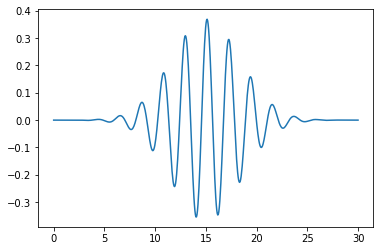

In [13]:
plt.figure()
plt.plot(times, np.real(omegaq(times, [])))
plt.show()

In [14]:
print(delta_off)

-2.9091147972241487


Great, now we ned to get the $|e, 1\rangle$ component in phase with the $|g, 2 \rangle$ component.

In [15]:
psi = psi0
n = 2
c1 = get_ind(psi, 0, n - 1)  # |e, n-1> 
c2 = get_ind(psi, 1, n)  # |g, n>
rotatetime = rotation_time(c1, c2)
print(rotatetime - 2 * np.pi)
times = time_axis(rotatetime)
result = sesolve(Hq, psi, times, [])
psi = result.states[-1]
psi.tidyup(atol=1e-3)
print("Psi data:")
print(psi.data)

0.0
0.0
-6.283185307179586


IndexError: index 0 is out of bounds for axis 0 with size 0

Notes: Try to connect this report to what we learned in the class